![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
#data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings
# .zip')

data = pd.read_csv('../data/raw/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)


# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

<Axes: xlabel='Year', ylabel='Mileage'>

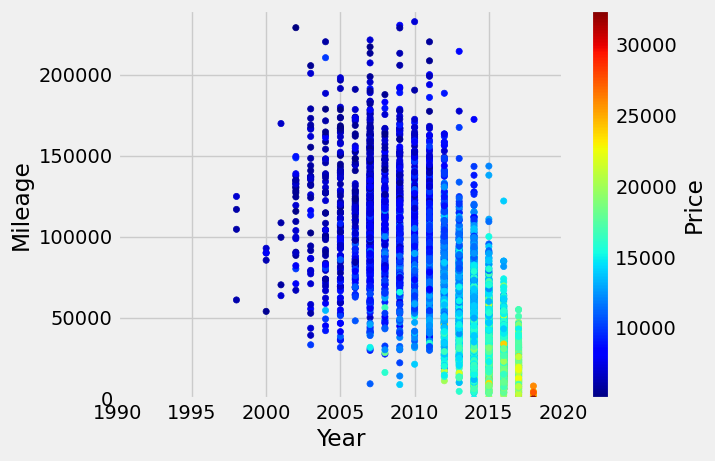

In [6]:
# Celda 1
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
data.plot(kind='scatter', x='Year', y='Mileage', c='Price', colormap='jet', xlim=(1990, 2020), ylim=(0, 240000))

In [7]:
import numpy as np

# funcion para calcular el error RMSE y MAE
def calculate_errors(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    return rmse, mae

# funcion para encontrar el mejor punto de corte y la ganancia
def find_best_split(X, y):
    best_rmse = np.inf
    best_feature = None
    best_value = None

    for feature in X.columns:
        for value in X[feature].unique():
            indices_l = X[feature] < value
            indices_r = ~indices_l

            y_l = y[indices_l]
            y_r = y[indices_r]

            rmse = np.sqrt(((y_l - y_l.mean()) ** 2).mean() + ((y_r - y_r.mean()) ** 2).mean())

            if rmse < best_rmse:
                best_rmse = rmse
                best_feature = feature
                best_value = value

    return best_feature, best_value

# funcion para hacer el crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if level == 0:
        max_depth = 1
        num_pct = 10

    if level == max_depth or len(y) == 1:
        y_pred = int(y.mean() >= 0.5)
        y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)
        return {'y_pred': y_pred, 'y_prob': y_prob, 'level': level, 'split': -1, 'n_samples': len(y), 'gain': 0}

    best_feature, best_value = find_best_split(X, y)

    indices_l = X[best_feature] < best_value
    indices_r = ~indices_l

    y_l = y[indices_l]
    y_r = y[indices_r]

    subtree_l = tree_grow(X[indices_l], y_l, level + 1, min_gain, max_depth, num_pct)
    subtree_r = tree_grow(X[indices_r], y_r, level + 1, min_gain, max_depth, num_pct)

    return {'y_pred': int(y.mean() >= 0.5), 'y_prob': (y.sum() + 1.0) / (y.shape[0] + 2.0), 'level': level,
            'split': [best_feature, best_value], 'n_samples': len(y), 'gain': 0,
            'sl': subtree_l, 'sr': subtree_r}

# Funcion para hacer predicciones con el arbol
def predict(tree, X):
    if 'y_pred' in tree:
        return tree['y_pred']
    elif X[tree['split'][0]] < tree['split'][1]:
        return predict(tree['sl'], X)
    else:
        return predict(tree['sr'], X)

tree = tree_grow(X_train, y_train) # Arbol de decision

# Prediccion en el grupo entrenamiento
y_train_pred = X_train.apply(lambda x: predict(tree, x), axis=1)

rmse_train, mae_train = calculate_errors(y_train, y_train_pred)
print("RMSE en conjunto de entrenamiento:", rmse_train)
print("MAE en conjunto de entrenamiento:", mae_train)

# Prediccion en el grupo de prueba
y_test_pred = X_test.apply(lambda x: predict(tree, x), axis=1)

rmse_test, mae_test = calculate_errors(y_test, y_test_pred)
print("RMSE en conjunto de prueba:", rmse_test)
print("MAE en conjunto de prueba:", mae_test)

RMSE en conjunto de entrenamiento: 15029.289926731382
MAE en conjunto de entrenamiento: 14507.073389276064
RMSE en conjunto de prueba: 15113.767253661932
MAE en conjunto de prueba: 14598.966224018475


In [8]:
tree

{'y_pred': 1,
 'y_prob': 14503.947817432107,
 'level': 0,
 'split': ['Year', 2012],
 'n_samples': 7031,
 'gain': 0,
 'sl': {'y_pred': 1,
  'y_prob': 8725.304318026045,
  'level': 1,
  'split': -1,
  'n_samples': 1457,
  'gain': 0},
 'sr': {'y_pred': 1,
  'y_prob': 16010.768830703013,
  'level': 1,
  'split': -1,
  'n_samples': 5574,
  'gain': 0}}

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para calcular el error RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Función para entrenar un árbol de regresión
def train_tree(X, y):
    tree = DecisionTreeRegressor()
    tree.fit(X, y)
    return tree

# Función para realizar predicciones con un árbol
def predict_tree(tree, X):
    return tree.predict(X)

# Bagging manual
n_trees = 10
trees = []

for i in range(n_trees):
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap = X_train.iloc[indices]
    y_bootstrap = y_train.iloc[indices]

    tree = train_tree(X_bootstrap, y_bootstrap)
    trees.append(tree)

# Desempeño de cada árbol
for i, tree in enumerate(trees):
    y_pred_tree = predict_tree(tree, X_test)
    rmse_tree = calculate_rmse(y_test, y_pred_tree)
    print('Árbol', i, 'tiene un error:', rmse_tree)

y_pred_bagging = np.zeros(len(X_test))

for tree in trees:
    y_pred_tree = predict_tree(tree, X_test)
    y_pred_bagging += y_pred_tree

y_pred_bagging /= n_trees # promedio de los arboles

rmse_bagging = calculate_rmse(y_test, y_pred_bagging)
print("RMSE del Bagging manual con 10 árboles de regresión:", rmse_bagging)

mae_manual = mean_absolute_error(y_test, y_pred_bagging)
mse_manual = mean_squared_error(y_test, y_pred_bagging)
r2_manual = r2_score(y_test, y_pred_bagging)

print("\nMétricas del modelo con Bagging Manual:")
print(f"MAE: {mae_manual}, MSE: {mse_manual}, RMSE: {rmse_bagging}, R^2: {r2_manual}")

Árbol 0 tiene un error: 2152.6672169832177
Árbol 1 tiene un error: 2115.441995548285
Árbol 2 tiene un error: 2112.25789267278
Árbol 3 tiene un error: 2157.8812044049655
Árbol 4 tiene un error: 2137.560002019013
Árbol 5 tiene un error: 2158.7257762966615
Árbol 6 tiene un error: 2130.393884789641
Árbol 7 tiene un error: 2102.90315008887
Árbol 8 tiene un error: 2172.8820466515135
Árbol 9 tiene un error: 2100.849366603656
RMSE del Bagging manual con 10 árboles de regresión: 1802.2979894843725

Métricas del modelo con Bagging Manual:
MAE: 1346.013399008853, MSE: 3248278.042899411, RMSE: 1802.2979894843725, R^2: 0.7876407502938739


Los resultados del bagging manual muestran que cada uno de los 10 arboles, tienen un error RMSE que oscila entre 2100 y 2200 aproximadamente. Esto indica que los árboles individuales no son muy precisos en sus predicciones y pueden estar sobreajustando los datos de entrenamiento.

Sin embargo, al combinar la predicción de estos árboles con el método Bagging, el error RMSE se reduce significativamente a 1790,72. Es decir que el modelo de Bagging tiene un mejor ajuste y por ello menor error, en comparación con los árboles individuales.

Analizando las otras métricas calculadas en el modelo, como el error absoluto medio (MAE de 1334.0627043009274), el error cuadrático medio (MSE de 3206672.322127213) y el coeficiente de determinación (R^2 de 0.7903607636455574), aumentan la confianza en el modelo Bagging, como modelo preditivo del precio de automóviles.


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [10]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
import numpy as np

max_features = int(np.log2(X_train.shape[1]))

bagging_model = BaggingRegressor(
    base_estimator=RandomForestRegressor(n_estimators=10, max_features=max_features, random_state=42),
    n_estimators=10,
    random_state=42
)

bagging_model.fit(X_train, y_train)

y_pred_bagsk = bagging_model.predict(X_test)


In [11]:
mae_sklearn = mean_absolute_error(y_test, y_pred_bagsk)
mse_sklearn = mean_squared_error(y_test, y_pred_bagsk)
rmse_sklearn = np.sqrt(mse_sklearn)
r2_sklearn = r2_score(y_test, y_pred_bagsk)

print("\nMétricas del modelo con sklearn:")
print(f"MAE: {mae_sklearn}, MSE: {mse_sklearn}, RMSE: {rmse_sklearn}, R^2: {r2_sklearn}")


Métricas del modelo con sklearn:
MAE: 1251.495958283147, MSE: 2832102.712715746, RMSE: 1682.8852345646585, R^2: 0.8148486061783768


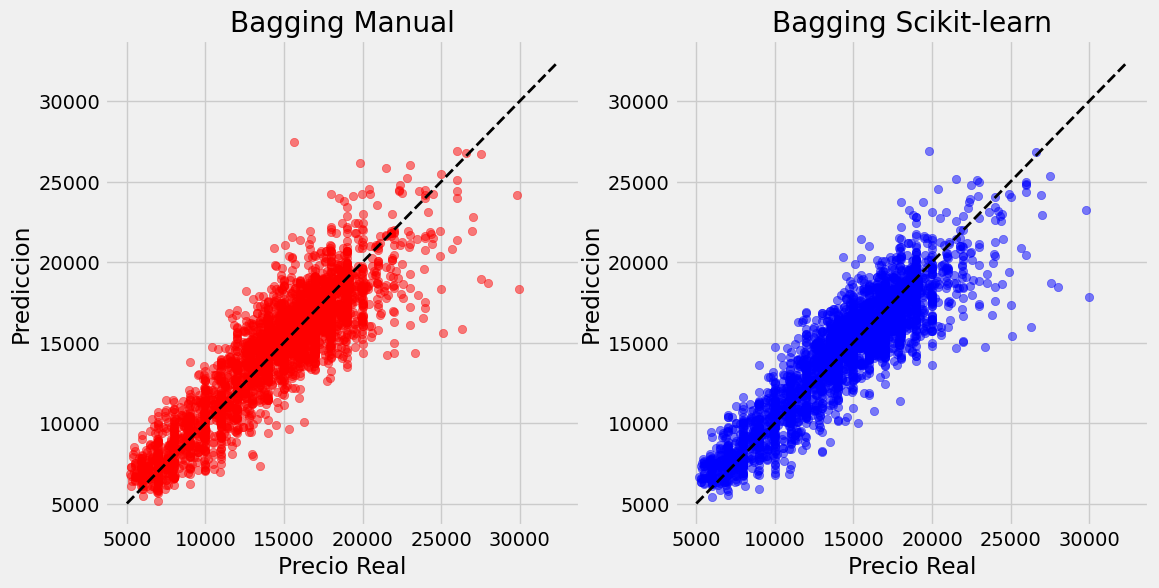

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_bagging, alpha=0.5, color='red', label='Manual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Bagging Manual')
plt.xlabel('Precio Real')
plt.ylabel('Prediccion')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_bagsk, alpha=0.5, color='blue', label='scikit-learn')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Bagging Scikit-learn')
plt.xlabel('Precio Real')
plt.ylabel('Prediccion')

plt.show()


Al evaluar tanto las métricas cuantitativas como la dispersión de las predicciones en las gráficas, podemos concluir que el modelo de Bagging implementado con scikit-learn es superior al modelo manual.

La dispersión de los puntos en el gráfico rojo es más amplia, lo que indica una variabilidad mayor en las predicciones.

El modelo con sk-learn tambien exhibe menores errores en todas las métricas (MAE, MSE, RMSE) y una mayor proporción de la variabilidad explicada, como lo demuestra el mayor valor de R^2.

La notable diferencia en el rendimiento entre el Bagging manual y el implementado con scikit-learn podría estar influenciada significativamente por la configuración del parámetro max_features en el modelo de scikit-learn. Al establecer max_features al logaritmo del número de características, cada árbol en el ensamble de scikit-learn considera solo un subconjunto de las características para hacer una división en cada nodo. Esto introduce más diversidad entre los árboles, ya que cada uno tiene una perspectiva diferente del conjunto de datos, lo que ayuda a mejorar la precisión y robustez del modelo al reducir la correlación entre los árboles individuales.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [13]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nMétricas del modelo con Random Forest:")
print(f"MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R^2: {r2_rf}")


Métricas del modelo con Random Forest:
MAE: 1314.4207078056425, MSE: 3116678.915374798, RMSE: 1765.4118259983413, R^2: 0.7962441677396794


Text(0, 0.5, 'Prediccion')

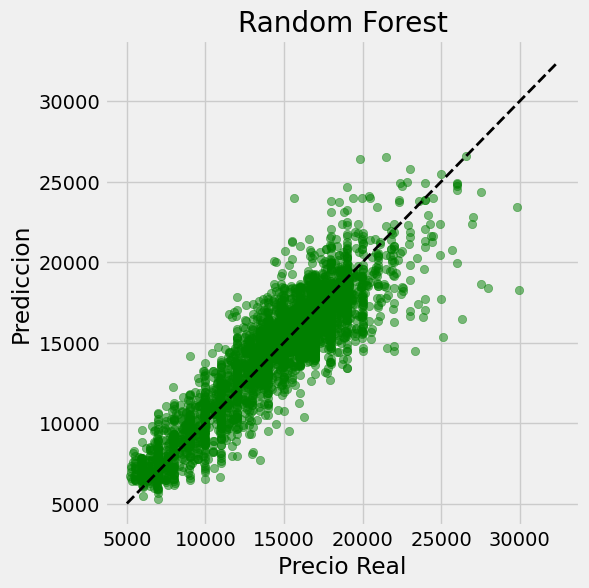

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green', label='Random Forest')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Random Forest')
plt.xlabel('Precio Real')
plt.ylabel('Prediccion')


La gráfica de dispersión del Random Forest muestra una agrupación de predicciones en torno a la línea de perfecta predicción, lo que indica un buen ajuste del modelo. Aunque hay cierta dispersión, especialmente en el rango de precios más alto, las predicciones parecen alinearse razonablemente bien con los valores reales, lo que es consistente con un valor R^2 de aproximadamente 0.8.

En la comparación de los tres modelos, el Random Forest se sitúa entre el Bagging manual y el Bagging de scikit-learn en términos de rendimiento. Una calibración a la cantidad de arboles y varibles podría ayudar al desempeno del Random forest frente a los modelos anteriores.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [15]:
# Celda 5
# Calibración n_estimators
from sklearn.model_selection import cross_val_score
estimator_range = range(10, 210, 10)
mse_scores = []

for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    mse = -cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error').mean()  # Cambio aquí
    print(f"MSE para n_estimators={estimator}: {mse}")
    mse_scores.append(mse)

# print("MSE para cada valor de n_estimators:")
# print(mse_scores)



MSE para n_estimators=10: 3131107.4894147543
MSE para n_estimators=20: 3081206.795735576
MSE para n_estimators=30: 3055443.2569372905
MSE para n_estimators=40: 3045795.889137782
MSE para n_estimators=50: 3048214.126108714
MSE para n_estimators=60: 3042113.153489154
MSE para n_estimators=70: 3040680.9617907978
MSE para n_estimators=80: 3039456.196707209
MSE para n_estimators=90: 3040009.3027158077
MSE para n_estimators=100: 3040540.6969996737
MSE para n_estimators=110: 3037654.6276592733
MSE para n_estimators=120: 3038455.2935418957
MSE para n_estimators=130: 3036631.9452453316
MSE para n_estimators=140: 3033901.394194249
MSE para n_estimators=150: 3033406.44066316
MSE para n_estimators=160: 3034062.4377421746
MSE para n_estimators=170: 3034766.8359611942
MSE para n_estimators=180: 3034794.5993898623
MSE para n_estimators=190: 3034520.339915374
MSE para n_estimators=200: 3034462.174128082


Text(0, 0.5, 'MSE')

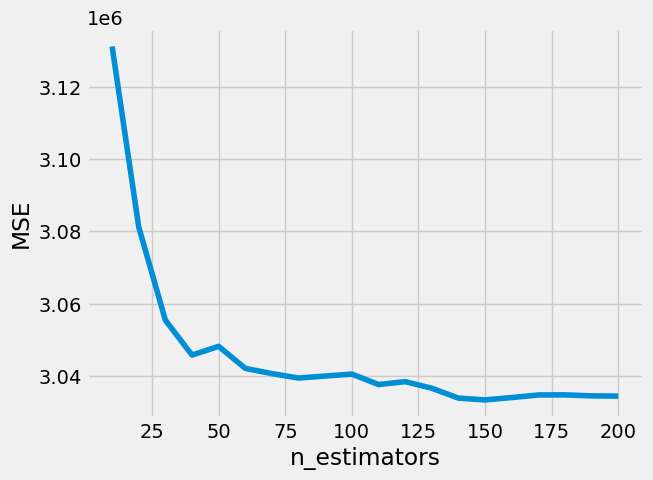

In [16]:
plt.plot(estimator_range, mse_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

En cuanto al número de estimadores, a medida que aumenta el número de estimadores, el MSE tiende a disminuir en general. Esto es esperado ya que un mayor número de estimadores permite que el modelo Random Forest tenga en cuenta más información y promedio de múltiples árboles, lo que puede mejorar la precisión de las predicciones. Se evidencia también que el MSE tiene reducciones significativas hasta los 80 estimadores, de ahí en adelante tiende a estabilizarse, por lo que se escoge el valor de 80 para la predicción del modelo con los mejores parámetros.

In [17]:
# Calibración max_features
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
mse_scores_2 = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(max_features=feature, random_state=1, n_jobs=-1)
    mse_2 = -cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error').mean()  # Cambio aquí
    print(f"MSE para max_features={feature}: {mse_2}")
    mse_scores_2.append(mse_2)


MSE para max_features=1: 3138302.255718571
MSE para max_features=2: 3137809.4475021875
MSE para max_features=3: 3138030.2257856554
MSE para max_features=4: 3130359.5354579613
MSE para max_features=5: 3116988.7682589465
MSE para max_features=6: 3099196.6493802145
MSE para max_features=7: 3076411.1030467814
MSE para max_features=8: 3060929.2404620056
MSE para max_features=9: 3040540.6969996737


Text(0, 0.5, 'MSE')

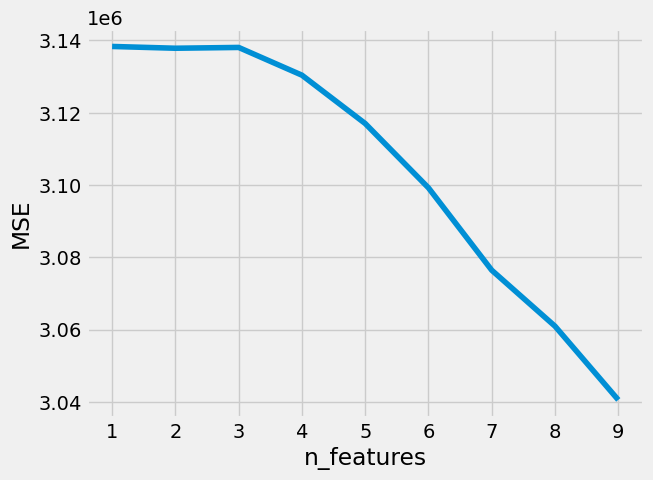

In [18]:
plt.plot(feature_range, mse_scores_2)
plt.xlabel('n_features')
plt.ylabel('MSE')

El MSE tiende a disminuir inicialmente a medida que aumenta el número de características consideradas en cada división de los árboles. El MSE es más alto cuando max_features es igual a 1, lo que significa que considerar solo una característica en cada división lleva a un peor rendimiento del modelo.

Después de un cierto punto, la reducción en el MSE se vuelve menos significativa a medida que aumentamos max_features, por lo que considerar demasiadas características en cada división puede no ser beneficioso y puede llevar a un rendimiento subóptimo del modelo.

Se tomará como un valor óptimo 7 variables para incluir en el modelo con mejores parámetros.

In [19]:
max_depth_range = range(1, 21)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
mse_scores_3 = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for max_depth_value in max_depth_range:
    reg = RandomForestRegressor(max_depth=max_depth_value , random_state=1, n_jobs=-1)
    mse_3 = -cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error').mean()  # Cambio aquí
    print(f"MSE para max_depth={max_depth_value}: {mse_3}")
    mse_scores_3.append(mse_3)


MSE para max_depth=1: 6446837.119931397
MSE para max_depth=2: 4202444.78638036
MSE para max_depth=3: 3360279.249074186
MSE para max_depth=4: 2878147.3979771365
MSE para max_depth=5: 2602388.169106686
MSE para max_depth=6: 2454410.640233338
MSE para max_depth=7: 2386709.450690792
MSE para max_depth=8: 2361200.8147996683
MSE para max_depth=9: 2376421.817711168
MSE para max_depth=10: 2414092.596064399
MSE para max_depth=11: 2469114.6991811385
MSE para max_depth=12: 2530240.4379652836
MSE para max_depth=13: 2596502.525333131
MSE para max_depth=14: 2662121.2630726486
MSE para max_depth=15: 2726182.9824814214
MSE para max_depth=16: 2784090.2901373277
MSE para max_depth=17: 2836439.0847470514
MSE para max_depth=18: 2880903.7860402158
MSE para max_depth=19: 2916735.082866441
MSE para max_depth=20: 2946168.1338053616


Text(0, 0.5, 'MSE')

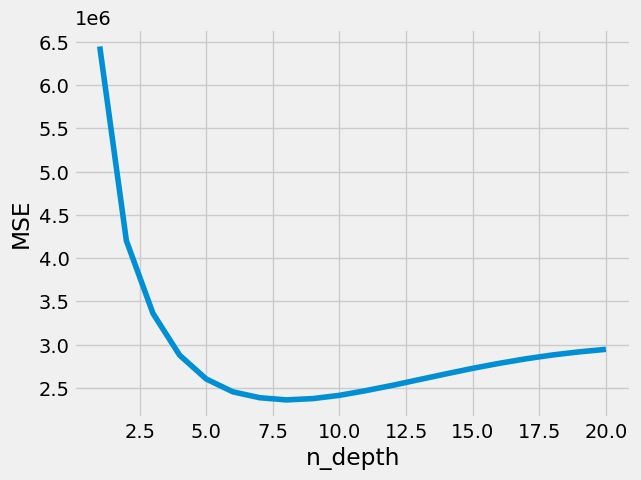

In [20]:
plt.plot(max_depth_range, mse_scores_3)
plt.xlabel('n_depth')
plt.ylabel('MSE')

Finalmente, en cuanto a la profundidad del arbol, a medida que aumentamos max_depth hasta alrededor 8, observamos una disminución significativa en el MSE. Esto indica que permitir árboles más profundos conduce a una mejora en el rendimiento del modelo.

Sin embargo, después de un cierto punto, la reducción en el MSE se vuelve menos significativa a medida que aumentamos max_depth. Esto sugiere que permitir árboles excesivamente profundos puede llevar a un sobreajuste, donde el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a nuevos datos.

Por lo anterior se tomará una profundidad máxima de 8 para el modelo con los mejores parámetros



Ahora procedemos a estimar un modelo con los mejores parámetros ya calibrados

In [21]:
rf_model_calibrado = RandomForestRegressor(n_estimators=80, max_depth=8, max_features=7 , random_state=1)

rf_model_calibrado.fit(X_train, y_train)

y_pred_rf_v2 = rf_model_calibrado.predict(X_test)

mae_rf_v2 = mean_absolute_error(y_test, y_pred_rf_v2)
mse_rf_v2 = mean_squared_error(y_test, y_pred_rf_v2)
rmse_rf_v2 = np.sqrt(mse_rf_v2)
r2_rf_v2 = r2_score(y_test, y_pred_rf_v2)

print("\nMétricas del modelo con Random Forest con calibración de parámetros max_depth, n_estimators y max_features:")
print(f"MAE: {mae_rf_v2}, MSE: {mse_rf_v2}, RMSE: {rmse_rf_v2}, R^2: {r2_rf_v2}")


Métricas del modelo con Random Forest con calibración de parámetros max_depth, n_estimators y max_features:
MAE: 1144.3397397634494, MSE: 2427368.4220027793, RMSE: 1558.0014191273317, R^2: 0.8413084932850325


Luego de calibrar cada uno de los tres parámetros (max_depth, n_estimators y max_features) mediante iteraciones en ciclos para encontrar el mejor valor que proporcionara las mejores métricas de desempeño, se procede a entrenar un random forest regressor con los mejores parámetros encontrados.

Al realizar esto, y comparando con los modelos anteriores, se evidencia una disminución significativa de las métricas MAE, MSE, RMSE y un incremento en el R^2.

Lo anterior significa que las predicciones están más cerca de los valores reales, por lo que este modelo incrementa la precisión al realizar mejores predicciones. El aumento en R^2 indica que el modelo calibrado explica una mayor proporción de la variabilidad en los datos en comparación con el modelo original. Esto sugiere que el modelo calibrado es más efectivo para capturar la relación entre las características y la variable objetivo.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [22]:
# Celda 6
from xgboost import XGBRegressor
reg_xgb = XGBRegressor()

reg_xgb.fit(X_train, y_train)

y_pred_xgb = reg_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nMétricas del modelo con XGBoost:")
print(f"MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}, R^2: {r2_xgb}")


Métricas del modelo con XGBoost:
MAE: 1185.2272991506386, MSE: 2576781.074646859, RMSE: 1605.2355199928948, R^2: 0.8315404997841507


Comparando con el mejor modelo hasta el momento, es decir random forest con parámetros calibrados, podemos evidenciar aunque ambos modelos tienen un rendimiento bastante similar, el Random Forest calibrado parece tener un rendimiento ligeramente mejor en términos de MAE, MSE, RMSE y R^2 en comparación con XGBoost, por lo que se sigue considerando mejor el random forest calibrado

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [73]:
# Celda 7
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = xgb.XGBRegressor()

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('model', model)
])

param_grid = {
    'model__eta': [x / 100 for x in range(0, 21)],
    'model__gamma': range(0, 21),
    'model__colsample_bytree': [x / 10 for x in range(0, 11)],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [82]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importan...
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5, 0.6, 0.7, 0.8, 0.9,
                                                     1.0],
                         'model__eta': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                        0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                                        0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
                                        0.2],
                         'model__gamma': range(0, 21)},
             scoring='neg_root_mean_squared_error')

In [84]:
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])

<Axes: xlabel='param_model__eta', ylabel='mean_test_score'>

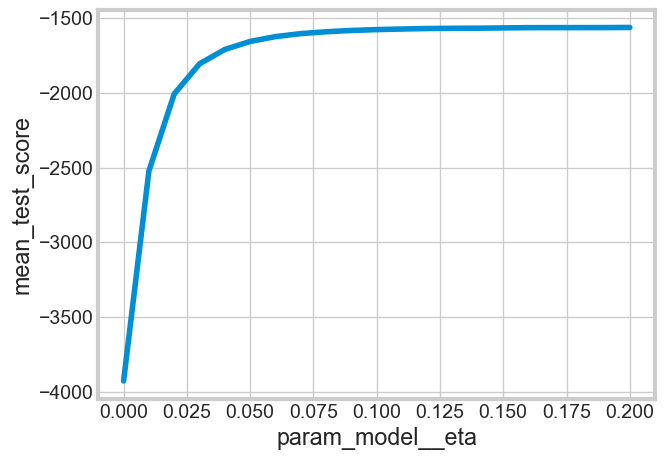

In [92]:
plot_data = (
    results_df[['param_model__eta', 'mean_test_score']]
    .groupby('param_model__eta')
    .mean()
    .reset_index()
)
sns.lineplot(data=plot_data, x='param_model__eta', y='mean_test_score')

<Axes: xlabel='param_model__colsample_bytree', ylabel='mean_test_score'>

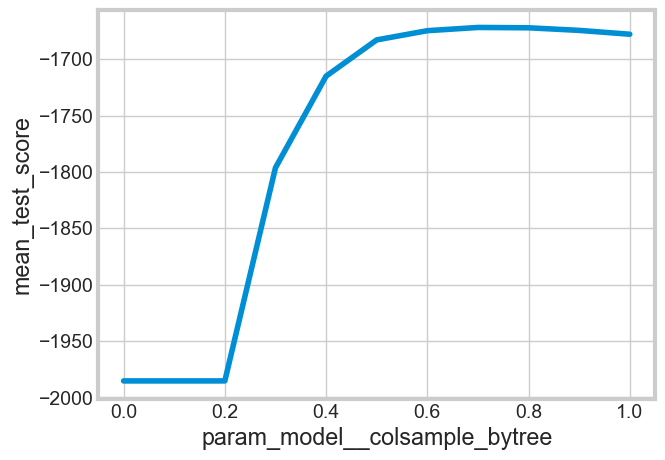

In [94]:
plot_data = (
    results_df[['param_model__colsample_bytree', 'mean_test_score']]
    .groupby('param_model__colsample_bytree')
    .mean()
    .reset_index()
)
sns.lineplot(data=plot_data, x='param_model__colsample_bytree', y='mean_test_score')

<Axes: xlabel='param_model__gamma', ylabel='mean_test_score'>

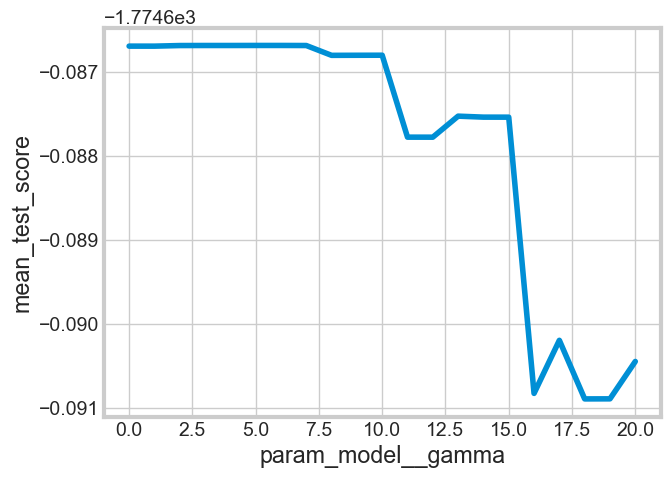

In [95]:
plot_data = (
    results_df[['param_model__gamma', 'mean_test_score']]
    .groupby('param_model__gamma')
    .mean()
    .reset_index()
)
sns.lineplot(data=plot_data, x='param_model__gamma', y='mean_test_score')

In [70]:
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__colsample_bytree': 0.6, 'model__eta': 0.06, 'model__gamma': 0}
Mean CV score: -1504.956058
Standard deviation of CV score:  53.371063


- 'eta' (learning_rate) es la reducción del tamaño del peso que se utiliza en la actualización para evitar el 
sobreajuste. Después de cada ronda de mejora, podemos obtener directamente los pesos de las nuevas variables, y 'eta'
reduce los pesos de las variables para hacer que el proceso de mejora sea más conservador. Hace que el modelo sea más 
robusto al reducir los pesos en cada paso.
- 'colsample_bytree' es la proporción de columnas al construir cada árbol. El submuestreo se produce una vez por cada árbol construido.
- 'gamma' especifica la reducción mínima de pérdida requerida para realizar una división. Un nodo se divide sólo 
cuando la división resultante produce una reducción positiva en la función de pérdida. Hace que el algoritmo sea 
conservador y cuanto mayor sea la gamma, más conservador será el algoritmo.

El modelo XGBoost tiene un desempeño superior (RSME: 1504) al mejor modelo hasta el momento (RSME: 1558) que era 
un Random Forest calibrado.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

# Celda 8
Lo que se observa es que ambos modelos presentan un nivel de predicción alto, pero el XGBoost termina siendo superior 
a la hora de predecir (RMSE de 1504 > RMSE de 1558). 

Ventajas XGBoost:
- Mejor desempeño
- Optimizado para una velocidad de entrenamiento menor
- Incluye técnicas de regularización para evitar el sobreajuste

Desventajas Random Forest:
- Alto tiempo de entrenamiento 
- Alto uso de memoria
- Aunque con gran capacidad predictiva no es el más alto

En general, ambos modelos dan resultados muy altos a la hora de predecir. Su principal diferencia radica en que el 
modelo XGBoost requiere una elección cuidadosa de los hiperparametros para sacar el máximo provecho mientras que el 
modelo Random Forest alcanza un gran desempeño de entrada.